In [25]:
import os
from dotenv import load_dotenv
import pandas as pd
from lib.utils import enzyme_split30_preprocessing, read_h5, apply_embedding, read_fasta, calculate_f1, bootstrap_statistic, round_to_significance

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef
import joblib

In [26]:
mode = "test"

In [27]:
load_dotenv()
if mode == "train":
    path_to_non_enzymes = os.getenv("FASTA_NON_ENZYMES", "fasta not found")
    path_to_enzyme_csv = os.getenv("CSV30_ENZYMES", "csv not found")
    path_to_esm2_ne = os.getenv("ESM2_NON_ENZYMES", "esm2 ne not found")
    path_to_esm2 = os.getenv("ESM2_ENZYMES_SPLIT_30", "esm2 not found")
elif mode == "test":
    path_to_non_enzymes = os.getenv("TEST_FASTA_NON_ENZYMES", "fasta not found")
    path_to_enzyme_csv = os.getenv("TEST_CSV_ENZYMES", "csv not found")
    path_to_esm2_ne = os.getenv("TEST_ESM2_NON_ENZYMES", "esm2 ne not found")
    path_to_esm2 = os.getenv("TEST_ESM2_ENZYMES", "esm2 not found")

#path_to_enzyme_csv_esm2 = os.getenv("CSV30_ENZYMES_ESM25_APPLIED")
#path_to_non_enzymes_esm2 = os.getenv("NON_ENZYMES_ESM2_APPLIED")

In [28]:
enzymes=pd.read_csv(path_to_enzyme_csv, delimiter=",")
print("RAW ENZYMES SIZE: " + str(enzymes.count()))
enzymes = enzyme_split30_preprocessing(enzymes)
print("PREPROCESSED ENZYMES SIZE: " + str(enzymes.count()))
enzymes.head()

RAW ENZYMES SIZE: Entry        392
EC number    392
Sequence     392
dtype: int64
PREPROCESSED ENZYMES SIZE: ID              334
EC number       334
Sequence        334
Enzyme class    334
dtype: int64


,ID,EC number,Sequence,Enzyme class
0,E0VIU9,2.3.2.31,MSILEWFWNILCGMAQYLTFSKNLTNDNLVNIYVKSNVGGTISVNL...,2
1,Q838J7,4.2.1.113,MNIQSIETYQVRLPLKTPFVTSYGRLEEKAFDLFVITDEQGNQGFG...,4
2,B1VB82,2.7.1.177,MAVAQCPASCGELIQGWILGSEKLVSCPVEWYSTVEVTSGSPLTDE...,2
3,R9QMR1,4.2.3.121,MALVSAVPLNSKLCLCRTLFGFSHELKAIHSTVPNLGMCRGGKSIA...,4
4,R9QMW2,4.2.3.121,MALVSAVPLNSKLCLCRTLFGFSHELKAIHSTVPNLGMCRGGKSIA...,4


In [29]:
enzymes = apply_embedding(read_h5(path_to_esm2, False), enzymes)
enzymes.head()

apply embedding
Index(['ID', 'Embedding'], dtype='object')
Index(['ID', 'EC number', 'Sequence', 'Enzyme class'], dtype='object')


,ID,Embedding,EC number,Sequence,Enzyme class
0,A0A011QK89,"[-0.0019319912, -0.016816322, 0.028769402, -0....",1.1.99.2,MESIEAVVIGAGVVGLACARELARRGFETVILERHGAFGTETSARN...,1
1,A0A067XR63,"[-0.05900694, 0.019138305, 0.005838026, -0.002...",2.4.1.207,MNAEGGNLHREFEITWGDGRARIHNNGGLLTLSLDRASGSGFRSKN...,2
2,A0A067XRK9,"[-0.055320676, 0.0015649835, 0.06592601, -0.04...",2.4.1.207,MASSLTLPMAMAFTLLALSFASAMGGSMNSSRFDELFQPSWAFDHF...,2
3,A0A067YMX8,"[-0.05380216, 0.0067072976, 0.035263997, -0.03...",2.4.1.207,MAASPYSIFAVQLLLLASWMLSSSSSNFNQDFNIAWGGGRARILNN...,2
4,A0A075HNX4,"[0.053292472, -0.03966276, -0.0039877286, -0.0...",1.1.3.20,MAQGAQRKNFGHNQILRPSAAYTPVDEQEVLQILDRHRGQRIRAVG...,1


In [30]:
non_enzymes = read_fasta(path_to_non_enzymes)
print("NON-ENZYMES SIZE: " + str(non_enzymes.count()))
non_enzymes.head()

NON-ENZYMES SIZE: ID          9876
Sequence    9876
dtype: int64


,ID,Sequence
0,P86725,MGYFPYLAVFVCLLASGDAQWKGLRGSTKASWVRVVSPTLNVTQEA...
1,A3EXD3,MDDSMDLDLDCVIAQPSSTIVMMPLSPISTRKRRRHPMNKRRYAKR...
2,P25602,MTYKLDRNSLRQQVMSPQSNASENIINLSSPNNYKQWLYGIETAAE...
3,P08611,DVPKSDQFVGLM
4,P08452,MLGRSLTSVLIVPTGIGCAVGGYAGDALPLARAIASVSDRLITHPN...


In [31]:
non_enzymes = apply_embedding(read_h5(path_to_esm2_ne, False), non_enzymes)
non_enzymes.head()

apply embedding
Index(['ID', 'Embedding'], dtype='object')
Index(['ID', 'Sequence'], dtype='object')


,ID,Embedding,Sequence
0,A0A023FF81,"[0.073902965, 0.024759796, 0.000958649, 0.0024...",MTSHSAVRIAIFAVIALHSIFECLSKPQILQRTDKSTDSEWDPQTC...
1,A0A023PXB0,"[0.011576651, -0.07352974, 0.016337689, -0.044...",MFINGFVNYPVRTPPNDLLQVVLHGFLRCPLDGSQVDSIGIGHTVH...
2,A0A023PXD9,"[-0.014599198, -0.07421142, 0.02527285, -0.000...",MIKKSRTYYPSFGAYFHLLPAHPNAHSVTLLFGIFRSSPFLLLFLL...
3,A0A023PXF5,"[0.012835482, -0.03668151, 0.106818296, -0.061...",MQVLIGTKLVTEGIDIKQLMMVIMLDNRLNIIELIQGVGRLRDGGL...
4,A0A023PXF8,"[0.05884727, -0.045268524, 0.057950538, -0.018...",MRIQKQQYTISSNSRINLLGILVLNVVCGKSSIFFSHPQRLGKLGG...


In [32]:
import numpy as np
# Split data
enzymes["Label"] = 1
non_enzymes["Label"] = 0

bin = pd.concat([enzymes[["Label", "Embedding"]], non_enzymes[["Label", "Embedding"]]], ignore_index=True)

bin = bin.sample(frac=1, random_state=42).reset_index(drop=True)

X = [value for value in bin["Embedding"]]
y = bin["Label"]
if mode == "train":
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    y_test = np.array(y_test)
elif mode == "test":
    X_test = X
    y_test = y
    y_test = np.array(y_test)



In [34]:
if mode == "train":
    k = 7
    knn_classifier = KNeighborsClassifier(n_neighbors=k)

    # Fit the classifier to the training data
    knn_classifier.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = knn_classifier.predict(X_test) # y_pred are predicted labels for embeddings at index
elif mode == "test":
    knn_classifier = joblib.load('./var/level0_esm2_knn.pkl')
    y_pred = knn_classifier.predict(X_test) # y_pred are predicted labels for embeddings at index


In [35]:
with open(f'./var/{mode}_knn_esm2_y_pred.txt', 'w') as file:
    for label in y_pred:
        file.write(f"{label}\n")
with open(f'./var/{mode}_knn_esm2_y_test.txt', 'w') as file:
    for label in y_test:
        file.write(f"{label}\n")

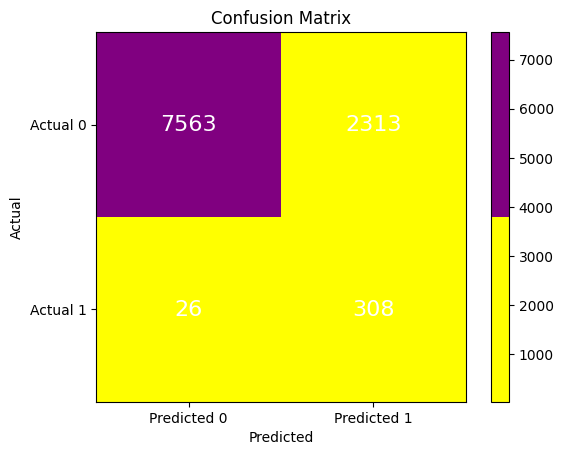

In [36]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
cm = confusion_matrix(y_test, y_pred)
# Define custom colors (e.g., green and purple)
colors = ['yellow', 'purple']

# Create a colormap using custom colors
cmap = mcolors.ListedColormap(colors)

# Plot the confusion matrix heatmap
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.colorbar()
plt.xticks([0, 1], ["Predicted 0", "Predicted 1"])
plt.yticks([0, 1], ["Actual 0", "Actual 1"])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

for i in range(2):
    for j in range(2):
        plt.text(j, i, str(cm[i, j]), ha='center', va='center', color='white', fontsize=16)

plt.show()

In [37]:
initial_f1 = calculate_f1(np.array(y_test), y_pred)
mean_f1, se_f1, ci_95 = bootstrap_statistic(y_test, y_pred, calculate_f1)
rounded_mean_f1, rounded_se_f1 = round_to_significance(mean_f1, se_f1)

[0.7714985308521056, 0.7644466209598433, 0.7746327130264447, 0.7754162585700294, 0.7720861900097943, 0.7680705190989227, 0.7659157688540646, 0.7704211557296766, 0.7679725759059746, 0.7750244857982369, 0.7773751224289912, 0.7698334965719884, 0.7736532810969636, 0.7787463271302644, 0.7655239960822723, 0.7755142017629775, 0.7756121449559256, 0.7751224289911851, 0.7681684622918707, 0.7732615083251715, 0.7680705190989227, 0.771694417238002, 0.7755142017629775, 0.7789422135161606, 0.7643486777668952, 0.7809990205680705, 0.7766895200783546, 0.7729676787463271, 0.7725759059745347, 0.7741429970617043, 0.7759059745347698, 0.7719882468168462, 0.7745347698334966, 0.7729676787463271, 0.7701273261508326, 0.7732615083251715, 0.7749265426052889, 0.7722820763956905, 0.7735553379040155, 0.7731635651322233, 0.773947110675808, 0.7648383937316356, 0.7701273261508326, 0.769343780607248, 0.7726738491674828, 0.7724779627815866, 0.7708129285014691, 0.7703232125367288, 0.7776689520078355, 0.7702252693437807, 0.

In [38]:
print(f"ESM2 KNN:")
print(f"  - Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"  - Initial F1 Score: {initial_f1:.2f}")
print(f"  - MCC: {matthews_corrcoef(y_test, y_pred)}")
print(f"  - Mean F1 ± SE F1: {rounded_mean_f1} ± {rounded_se_f1}")
print(f"  - 95% CI: [{ci_95[0]:.2f}, {ci_95[1]:.2f}]")

ESM2 KNN:
  - Accuracy: 0.7709108716944172
  - Initial F1 Score: 0.77
  - MCC: 0.28015336631327636
  - Mean F1 ± SE F1: 0.771 ± 0.0042
  - 95% CI: [0.76, 0.78]


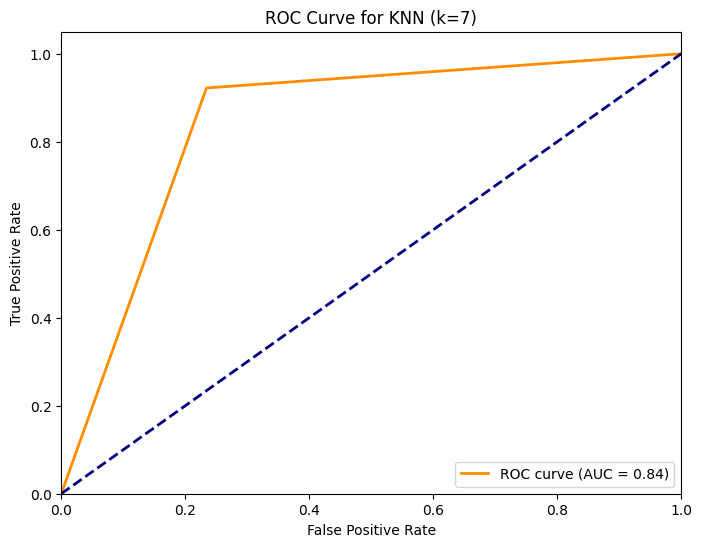

In [39]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
# roc curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Calculate the AUC (Area Under the ROC Curve)
roc_auc = auc(fpr, tpr)
# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for KNN (k=7)')
plt.legend(loc='lower right')
plt.show()

In [24]:
if mode == "train":
    joblib.dump(knn_classifier, './var/level0_esm2_knn.pkl')